# Horse or human?

Explore the dataset with 1000+ labelled CGI images of humans and horses

- Use TensorFlow ImageDataGenerator
- Use image augmentation to extend dataset "artifically" with TensorFlow

In [219]:
import tensorflow as tf
tf.__version__

'2.3.2'

In [220]:
# Fix issue that autocomplete is unresponsive
%config Completer.use_jedi = False

In [221]:
import urllib.request
import zipfile

### Get training data

In [222]:
url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip"
file_name = "horse-or-human.zip"
training_dir = "horse-or-human/training/"

In [ ]:
urllib.request.urlretrieve(url, file_name)

Unzip downloaded data

In [8]:
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(training_dir)

In [33]:
from IPython.display import display, Image
from os import path

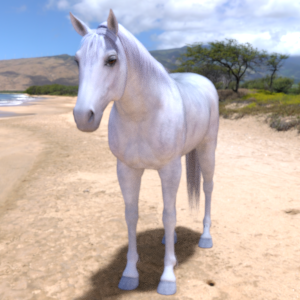

In [223]:
image = Image(path.join(training_dir, 'horses', 'horse01-0.png'))
display(image)

### Get validation data

In [224]:
validation_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip"
validation_file_name = "validation-horse-or-human.zip"
validation_dir = "horse-or-human/validation/"

In [ ]:
urllib.request.urlretrieve(validation_url, validation_file_name)

In [ ]:
with zipfile.ZipFile(validation_file_name, 'r') as zip_ref:
    zip_ref.extractall(validation_dir)

## Data pre-processing

In [225]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Instantiate generator and directory iterator that will rescale (normalize) RGB values and label (binary) all images in the training folder.

This can stream data into a model

In [244]:
train_datagen = ImageDataGenerator(
    rescale=1/255.,   # Normalize RGB values between 0 and 1
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [245]:
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(300, 300),  # all images are 300x300
    class_mode='binary'      # just two classes, otherwise categorical
)

Found 1027 images belonging to 2 classes.


In [246]:
validation_datagen = ImageDataGenerator(
    rescale=1/255.      # normalize RGB
)

In [247]:
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),  # all images are 300x300
    class_mode='binary'      # just two classes, otherwise categorical
)

Found 256 images belonging to 2 classes.


## Architecture

In [248]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [249]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 33, 33, 64)       

Idea:
- We end up with 7x7 feature maps after the last MaxPooling
- The subsequent dense network matches these features to labels

## Train the model

In [250]:
model.compile(
    loss='binary_crossentropy', # binary classification
    optimizer=tf.keras.optimizers.RMSprop(lr=0.001),  # Root Mean Square propagation
    metrics=['accuracy']
)

In [251]:
history = model.fit_generator(
    train_generator,
    epochs = 15,
    validation_data=validation_generator
)

Epoch 1/15
33/33 [==============================] - 66s 2s/step - loss: 0.7605 - accuracy: 0.5725 - val_loss: 0.5497 - val_accuracy: 0.7070
Epoch 2/15
33/33 [==============================] - 67s 2s/step - loss: 0.5468 - accuracy: 0.7429 - val_loss: 1.5217 - val_accuracy: 0.6328
Epoch 3/15
33/33 [==============================] - 65s 2s/step - loss: 0.3663 - accuracy: 0.8656 - val_loss: 0.7594 - val_accuracy: 0.7188
Epoch 4/15
33/33 [==============================] - 66s 2s/step - loss: 0.2565 - accuracy: 0.8958 - val_loss: 1.5055 - val_accuracy: 0.7148
Epoch 5/15
33/33 [==============================] - 64s 2s/step - loss: 0.2472 - accuracy: 0.9182 - val_loss: 2.1896 - val_accuracy: 0.6797
Epoch 6/15
33/33 [==============================] - 66s 2s/step - loss: 0.1716 - accuracy: 0.9367 - val_loss: 1.0805 - val_accuracy: 0.7266
Epoch 7/15
33/33 [==============================] - 64s 2s/step - loss: 0.1655 - accuracy: 0.9406 - val_loss: 1.3322 - val_accuracy: 0.7188
Epoch 8/15
33/33 [==

### Try out the model with some random real and out-of-sample images

In [252]:
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import matplotlib.pyplot as plt

In [253]:
test_dir = "horse-or-human/test/"

In [254]:
test_datagen = ImageDataGenerator(rescale=1/255.)

In [255]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    shuffle=False,
    seed=None,
    target_size=(300, 300),  # all images must be resized 300x300
    class_mode='binary'      # just two classes, otherwise categorical
)

Found 4 images belonging to 2 classes.


In [256]:
classes = model.predict(test_generator)    # classify the 4 images

In [257]:
train_generator.class_indices

{'horses': 0, 'humans': 1}

In [258]:
class_titles = ["human" if x > 0.5 else "horse" for x in classes]

In [259]:
imgs = test_generator.next()[0]            # data for the 4 images from the generator

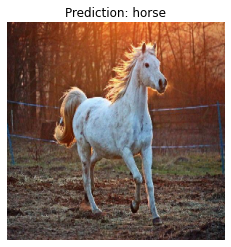

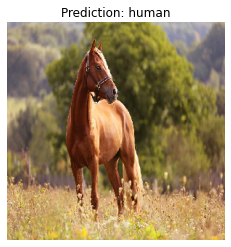

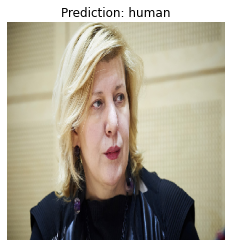

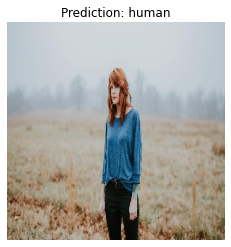

In [260]:
for ii in range(0,4):
    fig = plt.imshow(imgs[ii])
    plt.title("Prediction: " + class_titles[ii])
    plt.axis('Off')
    plt.show()

One horse is wrongly categorized, likely because of the pose

In [261]:
classes

array([[0.16460326],
       [0.99900854],
       [0.76792467],
       [1.        ]], dtype=float32)